Summary
### 1 - EDA + preprocessing

### 2 - Training of a linear regression model

### 3 - Training of regularized regression models

### Conclusion

# 1 - EDA + preprocessing

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("Walmart_Store_sales.csv")

In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print("Number of columns : {}".format(dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 150
Number of columns : 8

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [4]:
# Creating new columns with date values (year, month, date), to analyse each of them separately
dataset['Date'] = pd.to_datetime(dataset['Date'], infer_datetime_format=True)
dataset.loc[:, "Year"] = dataset["Date"].dt.year
dataset.loc[:, "Month"] = dataset["Date"].dt.month
dataset.loc[:, "Day"] = dataset["Date"].dt.day
dataset.loc[:, "Day_of_Week"] = dataset["Date"].dt.dayofweek
dataset = dataset.drop('Date', axis = 1)
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Day_of_Week
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
2,17.0,NaN,0.0,NaN,NaN,130.719581,5.936,2012.0,7.0,27.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0


In [5]:
dataset['Day_of_Week'].value_counts()

4.0    132
Name: Day_of_Week, dtype: int64

In [6]:
# Dropping "Day_of_Week" columns since we only have one value
dataset = dataset.drop('Day_of_Week', axis=1)

In [7]:
from plotly.subplots import make_subplots

# Distribution of each numeric variable
num_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig = make_subplots(rows = 5, cols = 1, subplot_titles = num_features)
for i in range(5):
    fig.add_trace(go.Histogram(x = dataset[num_features[i]], nbinsx = 50), row = i + 1,col = 1)
fig.update_layout(title = go.layout.Title(text = "Visualisation des variables quantitatives", x = 0.5), showlegend = False, autosize=False, height=1200)
fig.show()

# Barplot of each qualitative variable
cat_features = ['Store', 'Holiday_Flag','Year', 'Month', 'Day']
fig = make_subplots(rows = 5, cols = 1, subplot_titles = cat_features)
for i in range(5):
    x_coords = dataset[cat_features[i]].value_counts().index.tolist()
    y_coords = dataset[cat_features[i]].value_counts().tolist()
    fig.add_trace(go.Bar(x = x_coords,y = y_coords),row = i + 1,col = 1)

fig.update_layout(title = go.layout.Title(text = "Visualisation des variables qualitatives", x = 0.5), showlegend = False,autosize=False,  height=1200)

In [8]:
# Displaying total revenue by year
fig = px.histogram(dataset, x='Year', y= 'Weekly_Sales')
fig.update_xaxes(type='category', categoryorder="category ascending")
fig.show()

<AxesSubplot:>

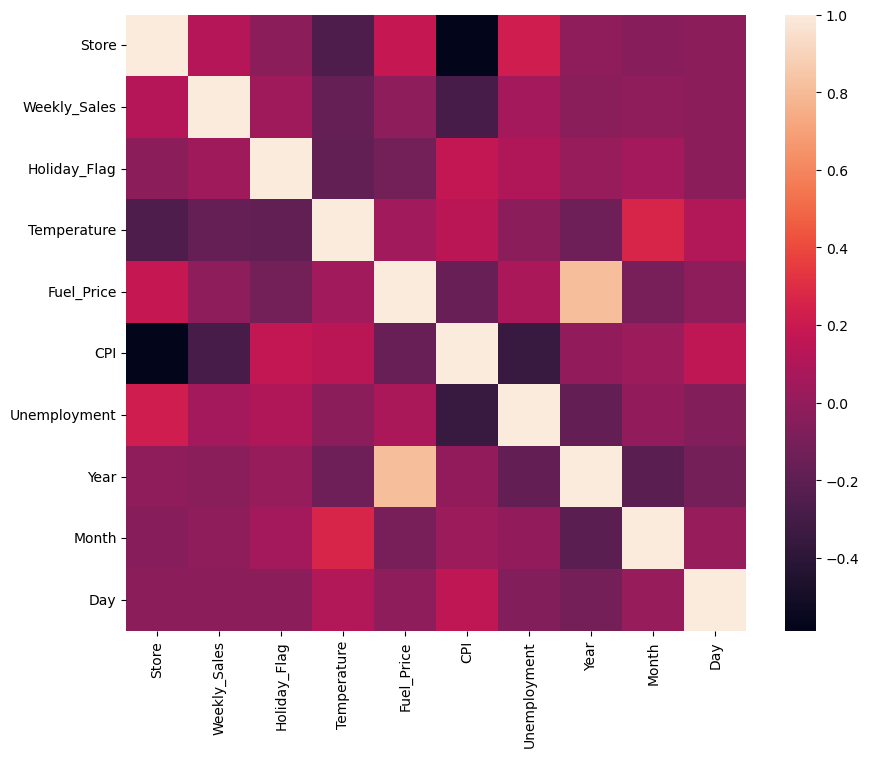

In [9]:
# Displaying correlation matrix
corr = dataset.corr()
_, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax)

There is no huge correlation between variables. We do not need to drop columns.

In [10]:
# Dropping lines with missing Y target
to_keep = dataset['Weekly_Sales'].notna()
dataset = dataset.loc[to_keep, :]
dataset.shape

(136, 10)

In [11]:
# Dropping lines with outliers
min_temp = dataset['Temperature'].mean() - (3 * dataset['Temperature'].std())
max_temp = dataset['Temperature'].mean() + (3 * dataset['Temperature'].std())

min_fuel = dataset['Fuel_Price'].mean() - (3 * dataset['Fuel_Price'].std())
max_fuel = dataset['Fuel_Price'].mean() + (3 * dataset['Fuel_Price'].std())

min_cpi = dataset['CPI'].mean() - (3 * dataset['CPI'].std())
max_cpi = dataset['CPI'].mean() + (3 * dataset['CPI'].std())

min_unemp = dataset['Unemployment'].mean() - (3 * dataset['Unemployment'].std())
max_unemp = dataset['Unemployment'].mean() + (3 * dataset['Unemployment'].std())

dataset = dataset[((dataset["Temperature"] < max_temp) & (dataset["Temperature"] > min_temp)) | (dataset["Temperature"].isnull())]
dataset = dataset[((dataset["Fuel_Price"] < max_fuel) & (dataset["Fuel_Price"] > min_fuel)) | (dataset["Fuel_Price"].isnull())]
dataset = dataset[((dataset["CPI"] < max_cpi) & (dataset["CPI"] > min_cpi)) | (dataset["CPI"].isnull())]
dataset = dataset[((dataset["Unemployment"] < max_unemp) & (dataset["Unemployment"] > min_unemp)) | (dataset["Unemployment"].isnull())]

dataset.shape

(131, 10)

In [12]:
# Separating target variable Y from features X
features_list = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
target_variable = ['Weekly_Sales']

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

In [13]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
# Creating pipeline for numeric features
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Year', 'Month', 'Day']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
    ])

In [15]:
# Creating pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

In [16]:
# Using ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Preprocessings on train set: doing the math and transforming the required values
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set: transforming the required values, with calculations made on the train set
# (If we made new calculations on the test set, like median, this would introduce bias)
X_test = preprocessor.transform(X_test)

c:\Users\marti\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



# 2 - Training of a linear regression model

In [18]:
# Training Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression()

In [19]:
# Predictions on training set
Y_train_pred = regressor.predict(X_train)

# Predictions on test set
Y_test_pred = regressor.predict(X_test)

In [20]:
# Printing R² scores
print("R² score on training set : ", r2_score(Y_train, Y_train_pred))
print("R² score on test set : ", r2_score(Y_test, Y_test_pred))

R² score on training set :  0.9740718051467115
R² score on test set :  0.9364528193143951


In [21]:
# Using a cross validation with 5 K-fold to check if model is overfitting
scores = cross_val_score(regressor, X_train, Y_train, cv = 5)
print(f'Scores obtained during the cross validation: {scores}')
print(f'The average of cross_val scores is {scores.mean()}')
print(f"The standard deviation on cross_val scores is {scores.std()}")

Scores obtained during the cross validation: [0.9243891  0.92488375 0.95603814 0.96989135 0.95616008]
The average of cross_val scores is 0.9462724841653415
The standard deviation on cross_val scores is 0.018370323615086594


The model is showing good results, with almost no overfitting.

In [22]:
# Extracting the names of the dummy variables created by OneHotEncoder
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # looping over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just getting the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out(categorical_features) # getting output columns names from OneHotEncoder
    column_names.extend(features) # concatenating features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Flag_1.0']


In [23]:
# Creating a pandas DataFrame to plot the feature importance from our model
dataset_coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"]).abs().sort_values(by = 'coefficients')

fig = px.bar(dataset_coefs, orientation = 'h',height=600)
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}) # to avoid cropping of column names
fig.show()

The variables that are most used by our model to make the predictions are the store ID ones.

# 3 - Training of regularized regression models

In [24]:
# Performing grid search with Ridge regularization
regressor_ridge = Ridge()

# Grid of values to be tested
params = {'alpha': [0.0, 0.5 , 1 , 1.5, 2]}
gridsearch_ridge = GridSearchCV(regressor_ridge, param_grid = params, cv = 5)
gridsearch_ridge.fit(X_train, Y_train)

# Getting best hyperparameter for best R² score
print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R² score : ", gridsearch_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.0}
Best R² score :  0.9462724841653418


The model with Ridge regularization offers almost the same prediction as the one without regularization.

When alpha = 0, it means no regularization is done.

In [25]:
# Performing grid search with Lasso regularization
regressor_lasso = Lasso()

# Grid of values to be tested
params = {'alpha': [15, 25, 35, 45, 55, 65, 75]}
gridsearch_lasso = GridSearchCV(regressor_lasso, param_grid = params, cv = 5)
gridsearch_lasso.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch_lasso.best_params_)
print("Best R² score : ", gridsearch_lasso.best_score_)

Best hyperparameters :  {'alpha': 45}
Best R² score :  0.946286513907248


The model with Lasso regularization offers performances slightly better than Ridge regularization.

# CONCLUSION

Our model seems quite robust. R² on test set is really high. R² on train test is also high, not far from the result from the train.

Almost no overfit with the data from our sample, the regularization is not changing the results a lot in our case.

We would need more data to be sure our model is robust enough to be used in production.